Analysis of wine quality based on data as published in a research paper:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. 
Decision Support Systems, Elsevier, 47(4):547-553, 2009. 
Data source available at http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### 1. Data preparation

In [23]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss, classification_report

from utils.ml.classification import confusion_matrix_visual

# read the data from files
red_wine = pd.read_csv("data/wine/winequality-red.csv", sep=';')
white_wine = pd.read_csv("data/wine/winequality-white.csv", sep=';')

# concatenate both wine categories to 
# create a compact dataset for EDA
wine = pd.concat([
    red_wine.assign(kind='red'),
    white_wine.assign(kind='white')
])

### 2. Exploratory data analysis

In [2]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [3]:
wine.info() # check the data types and missing values

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  kind                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


In [4]:
wine.kind.value_counts() # check how many records there are for each category

kind
white    4898
red      1599
Name: count, dtype: int64

Conslusion: We see that the red wine has much smaller sample size, which will impact the creation of the prediction model.

In [39]:
def describe(data, n_decimals=2):
  """Print descriptive statistics for the data."""

  desc = data.describe().apply(
    lambda x: round(x, n_decimals)
  ).T
    
  desc['count'] = desc['count'].astype(int)
  print(desc)

def plot_quality_score(data, kind):
  """Plot the distribution of wine quality."""

  sorted = data.quality.value_counts().sort_index()
  ax = sorted.plot.barh(
    title=f'{kind.title()} - Wine Quality Scores',
    figsize=(12, 3)
  )
  ax.axes.invert_yaxis()

  for bar in ax.patches:
    # number of wines with this quality score
    # as a percentage of the total number of wines
    offset_pts = 5
    percent = bar.get_width() / data.shape[0]
    pos_vertical_center = bar.get_y() + bar.get_height() / 2
    ax.text(
      bar.get_width() + offset_pts, 
      pos_vertical_center,
      f'{percent:.1%}', 
      va='center'
    )

  plt.xlabel('Count of wines')
  plt.ylabel('Quality score')

  # hide the top and right spines
  for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

  plt.show()

def plot_chemical_props(data):
  """Plot the chemical properties of the wine."""

  # examine each chemical property by visualizing in box plots
  chemical_props = set(data.columns).difference(['quality', 'high_quality', 'kind'])
  melted = data.drop(columns='quality').melt(id_vars=['kind'])

  fig, axes = plt.subplots(
    math.ceil(len(chemical_props) / 4), 4, figsize=(15, 10)
  )

  for ax, prop in zip(axes.flatten(), chemical_props):
    sns.boxplot(
      x='variable',
      y='value', 
      hue='kind',
      data=melted[melted.variable == prop],
      ax=ax,
      palette=["#FFFF99", "red"]
    ).set_xlabel('')

  for ax in axes[len(chemical_props):]:
    ax.remove() # remove empty subplots

  plt.suptitle('Chemical properties by wine type')
  plt.tight_layout()
  plt.show()

def plot_quality_scores(red_wine, white_wine):
  """Plot the quality scores of the wine."""

  plot_quality_score(red_wine, 'red wine')
  plot_quality_score(white_wine, 'white wine')

def print_metrics(pipeline, x_test, y_test, predictions):
    score = pipeline.score(x_test, y_test)
    loss = zero_one_loss(y_test, predictions)
    cls_report = classification_report(y_test, predictions)
    print(f'Score: {score:.2f}')
    print(f'Loss: {loss:.2f}')
    print('------------------------------------------------------')
    print('\t\tClassification report')
    print('------------------------------------------------------')
    print(cls_report)
    print('------------------------------------------------------')

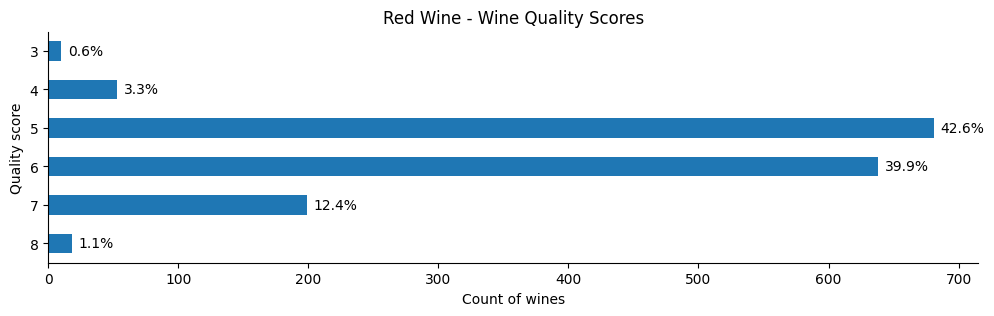

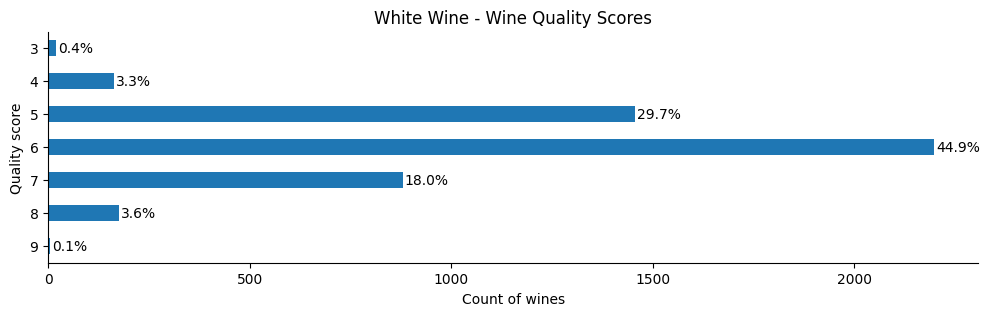

In [6]:
# examine the distribution of quality scores for both kinds of wine 
plot_quality_scores(red_wine, white_wine)

0 = inferior quality, 10 = exquisite quality
0 - 6 = low quality
7-10 =high quality

The above graph shows that the white wine exhibits higher quality (higher percentage of category 7-10 than red wine) than red wine as suggested by the authors.

In [7]:
# if there was a random sampling performed, and the evaluation was
# perfectly unbiased, then the quality scores whould exhibit normal 
# distribution for both wine categories (null hypothesis)
for kind, data in [('red', red_wine), ('white', white_wine)]:
  print(f'{kind.title()} wine quality scores:')
  val, p = shapiro(data.quality)
  print(f'Shapiro-Wilk test: {round(val, 3)} (p-value: {round(p,5)})')
  val, p = kstest(data.quality, 'norm')
  print(f'Kolmogorov-Smirnov test: {round(val, 3)} (p-value: {round(p,5)})')
  print('\n')

Red wine quality scores:
Shapiro-Wilk test: 0.858 (p-value: 0.0)
Kolmogorov-Smirnov test: 0.999 (p-value: 0.0)


White wine quality scores:
Shapiro-Wilk test: 0.889 (p-value: 0.0)
Kolmogorov-Smirnov test: 0.999 (p-value: 0.0)




**Conclusion:** For both categories, the null hypothesis holds. The quality scores are normally distributed.

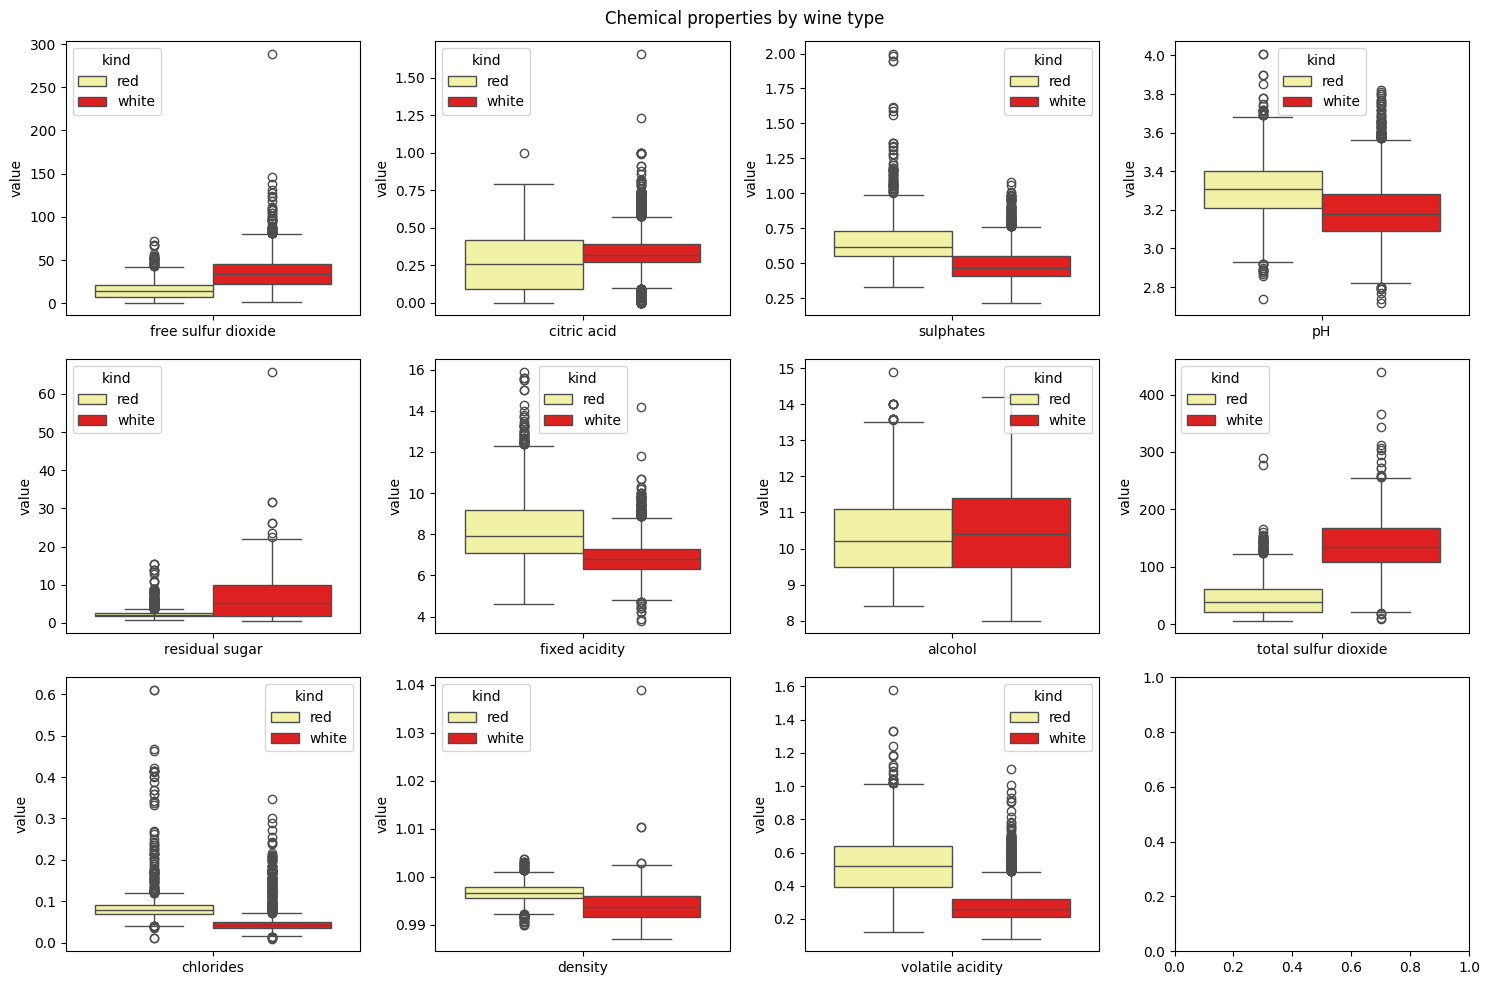

In [8]:
# examine the distribution of chemical properties - variables that differ
# in the distributions between red and white wine may be useful for feature
# selection for further modeling
plot_chemical_props(wine)

**Conslusion:** Form the above distribution plots, candidate varaibles for model building are fixed acidity, volatile acidity, total sulfur dioxide, sulphates, free sulfur dioxide, pH, chlorides, density, and residual sugar.

### 3. Model creation, training, evaluation

In [9]:
# categorize wine quality as low or high
low_quality = 0
high_quality = 1

# use the features with the greatest distance
# in their variability between red and white 
# wine, as detected in the EDA phase
feats = [
  'fixed acidity',
  'volatile acidity',
  'total sulfur dioxide',
  'sulphates',
  'free sulfur dioxide',
  'pH',
  'chlorides',
  'density',
  'residual sugar'
]

#### 3.1 Red wine predictions

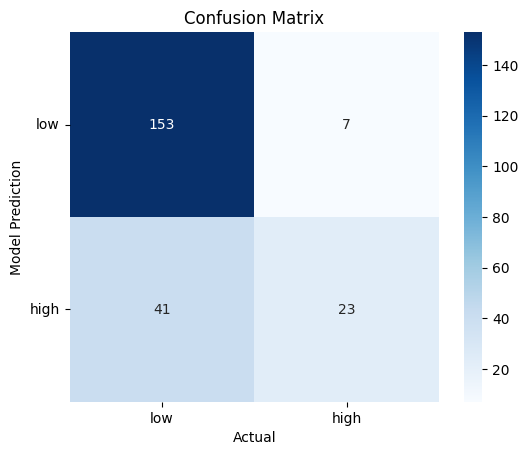

In [10]:
# classify the quality score as low or high;
# 0-6 = low quality; 7-10 = high quality
red_wine['high_quality'] = pd.cut(
  red_wine.quality,
  bins=[0, 6, 10],
  labels=[
      low_quality,
      high_quality
  ]
)

# prep data for machine learning
red_x = red_wine[feats]
red_y = red_wine['high_quality']

x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(
  red_x, red_y,
  test_size=0.14, # ideally between 10-30% of the data
  random_state=0,  # for reproducibility of shuffling
    stratify=red_y
)

# create processing pipeline involving a standardd
# standardd scaler (the vals of chemical props have
# distinct scales) and logistic regression for binary
# classification (into high and low quality). The model
# must use class balancing to ensure that wrong predictions
# white wine (smaller sample size)  will carry more weight.
red_quality_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced', 
        random_state=0
    ))
])

# train the model on the data
red_quality_pipeline.fit(x_train_red, y_train_red)

# evaluate the model on the testing data
prediction_red = red_quality_pipeline.predict(x_test_red)
_ = confusion_matrix_visual(y_test_red, prediction_red, ['low', 'high'])

In [38]:
print_metrics(red_quality_pipeline, x_test_red, y_test_red, prediction_red)

Score: 0.79
Loss: 0.21
------------------------------------------------------
		Classification report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       194
           1       0.36      0.77      0.49        30

    accuracy                           0.79       224
   macro avg       0.66      0.78      0.68       224
weighted avg       0.88      0.79      0.81       224

------------------------------------------------------


#### 3.2 White wine predictions

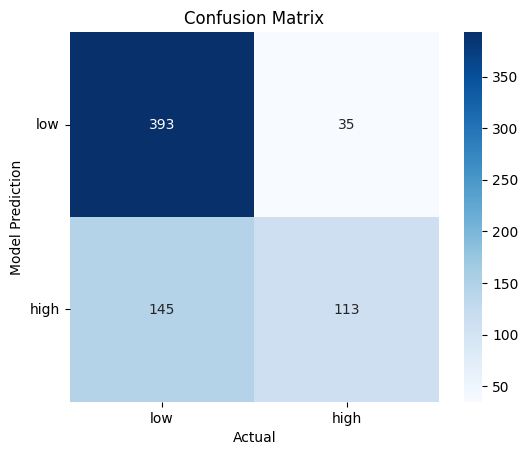

In [13]:
# classify the quality score as low or high;
# 0-6 = low quality; 7-10 = high quality
white_wine['high_quality'] = pd.cut(
  white_wine.quality,
  bins=[0, 6, 10],
  labels=[
      low_quality,
      high_quality
  ]
)

# predictions for the red wine
white_x = white_wine[feats]
white_y = white_wine['high_quality']

x_train_white, x_test_white, y_train_white, y_test_white = train_test_split(
  white_x, white_y,
  test_size=0.14,  # ideally between 10-30% of the data
  random_state=0,  # for reproducibility of shuffling
    stratify=white_y
)

# create processing pipeline involving a standardd
# standardd scaler (the vals of chemical props have
# distinct scales) and logistic regression for binary
# classification (into high and low quality). The model
# must use class balancing to ensure that wrong predictions
# white wine (smaller sample size)  will carry more weight.
white_quality_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced', 
        random_state=0
    ))
])

# train the model on the data
white_quality_pipeline.fit(x_train_white, y_train_white)

# evaluate the model on the testing data
predictions_white = white_quality_pipeline.predict(x_test_white)
_ = confusion_matrix_visual(y_test_white, predictions_white, ['low', 'high'])

In [44]:
print_metrics(white_quality_pipeline, x_test_white, y_test_white, predictions_white)

Score: 0.74
Loss: 0.26
------------------------------------------------------
		Classification report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       538
           1       0.44      0.76      0.56       148

    accuracy                           0.74       686
   macro avg       0.68      0.75      0.69       686
weighted avg       0.81      0.74      0.76       686

------------------------------------------------------


#### 3.3 Combined wine predictions

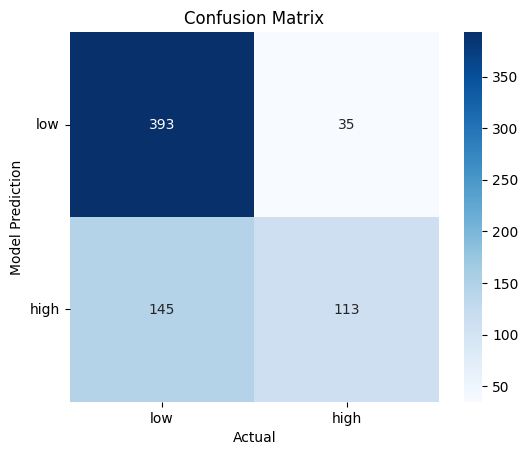

In [15]:
# classify the quality score as low or high;
# 0-6 = low quality; 7-10 = high quality
wine['high_quality'] = pd.cut(
  white_wine.quality,
  bins=[0, 6, 10],
  labels=[
      low_quality,
      high_quality
  ]
)

# predictions for the red wine
combined_x = white_wine[feats]
combined_y = white_wine['high_quality']

x_train_combined, x_test_combined, y_train_combined, y_test_combined = train_test_split(
  combined_x, combined_y,
  test_size=0.14,  # ideally between 10-30% of the data
  random_state=0,  # for reproducibility of shuffling
    stratify=combined_y
)

# create processing pipeline involving a standardd
# standardd scaler (the vals of chemical props have
# distinct scales) and logistic regression for binary
# classification (into high and low quality). The model
# must use class balancing to ensure that wrong predictions
# white wine (smaller sample size)  will carry more weight.
combined_quality_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced', 
        random_state=0
    ))
])

# train the model on the data
combined_quality_pipeline.fit(x_train_combined, y_train_combined)

# evaluate the model on the testing data
predictions_comb = combined_quality_pipeline.predict(x_test_combined)
_ = confusion_matrix_visual(y_test_combined, predictions_comb, ['low', 'high'])

In [42]:
print_metrics(combined_quality_pipeline, x_test_combined, y_test_combined, predictions_comb)

Score: 0.74
Loss: 0.26
------------------------------------------------------
		Classification report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       538
           1       0.44      0.76      0.56       148

    accuracy                           0.74       686
   macro avg       0.68      0.75      0.69       686
weighted avg       0.81      0.74      0.76       686

------------------------------------------------------


### 3.4 Predictions that wine is red or white from their chemical props

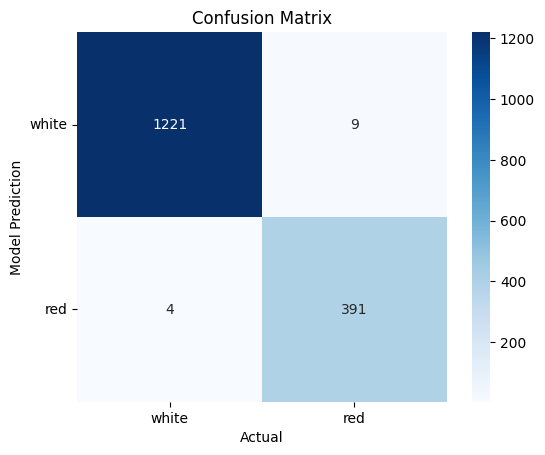

In [17]:
wine_y = np.where(wine.kind == 'red', 1, 0)
wine_x = wine.drop(columns=['quality', 'kind', 'high_quality'])

x_train, x_test, y_train, y_test = train_test_split(
  wine_x, wine_y,
  test_size=0.25,  # ideally between 10-30% of the data
  random_state=0,  # for reproducibility of shuffling
    stratify=wine_y
)

white_or_red = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(random_state=0))
])

# train the model
white_or_red.fit(x_train, y_train)

# evaluate the model perfforma
predictions = white_or_red.predict(x_test)
_ = confusion_matrix_visual(y_test, predictions, ['white', 'red'])

In [43]:
print_metrics(white_or_red, x_test, y_test, predictions)

Score: 0.99
Loss: 0.01
------------------------------------------------------
		Classification report
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1225
           1       0.99      0.98      0.98       400

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

------------------------------------------------------


**Conclusion:** The model predicts fairy well whether wine is red or white when taking all wine params as predictors.
Given that the quality scores are very subjective and not necessarily related to the
chemical properties, this simple model may not perform too well. On the other hand,
chemical properties are different between red and white wines, so this information
is more useful for the white_or_red model.